In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.5 MB/s eta 0:00:00



Median Filter Results:
PSNR: 25.60316424385194
SSIM: 0.685258510201808
MSE: 0.00275222271949357

Wavelet Denoising Results:
PSNR: 27.679987512707704
SSIM: 0.644395447849372
MSE: 0.0017060872945179261

Non-Local Means Results:
PSNR: 29.96584995006763


SSIM: 0.8910572102923968
MSE: 0.0010078943368387117


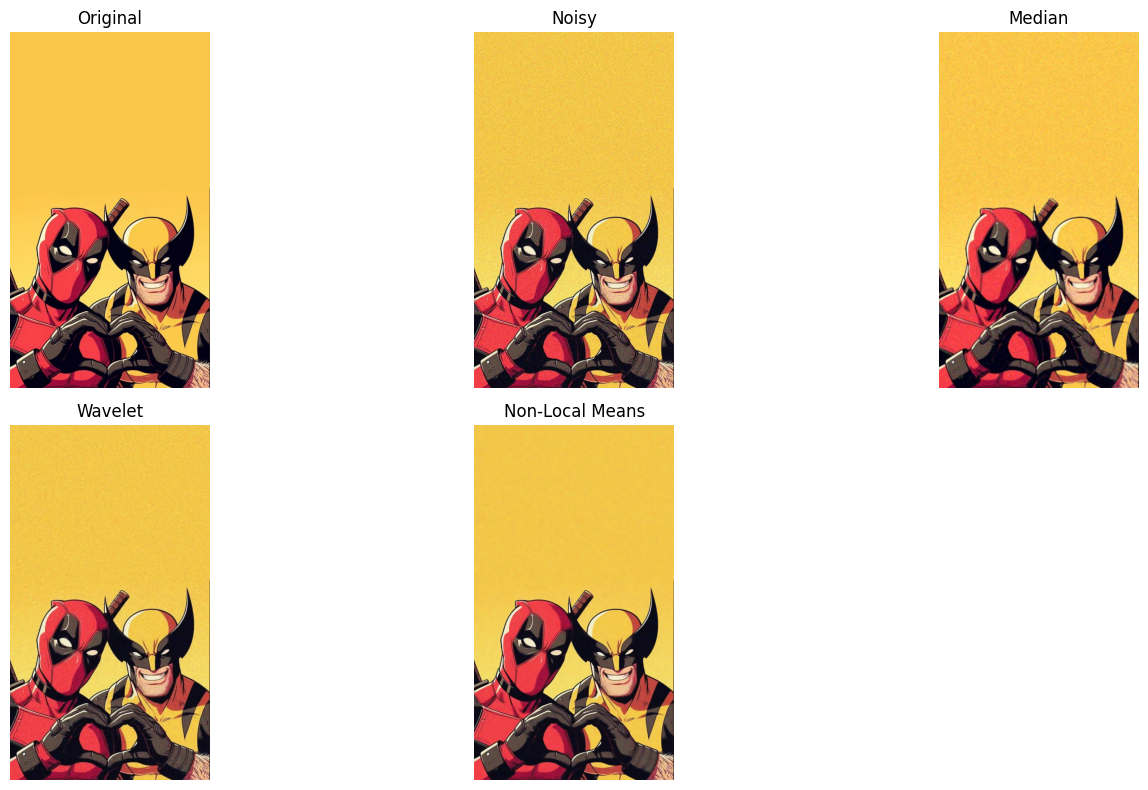

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, img_as_ubyte
from skimage.restoration import denoise_wavelet, denoise_nl_means, estimate_sigma
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim, mean_squared_error as mse
import os

# Load image
img_path = 'dandw.jpg'  # Replace this with your image file
if not os.path.exists(img_path):
    raise FileNotFoundError("Image not found. Please check the path.")

original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
original = img_as_float(original)

# Add synthetic Gaussian noise
noisy = random_noise(original, var=0.01)

# 1. Median Filter (apply on grayscale for simplicity)
noisy_uint8 = img_as_ubyte(noisy)
median = cv2.medianBlur(noisy_uint8, 5)
median = img_as_float(median)

# 2. Wavelet Denoising
wavelet = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft')

# 3. Non-Local Means (used as alternative to Noise2Void)
sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
nl_means = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=True,
                             patch_size=5, patch_distance=6, channel_axis=-1)

# Metrics
def evaluate(img_name, denoised):
    print(f"\n{img_name} Results:")
    print("PSNR:", psnr(original, denoised))
    print("SSIM:", ssim(original, denoised, channel_axis=-1, data_range=1.0))
    print("MSE:", mse(original, denoised))

evaluate("Median Filter", median)
evaluate("Wavelet Denoising", wavelet)
evaluate("Non-Local Means", nl_means)

# Plot results
titles = ['Original', 'Noisy', 'Median', 'Wavelet', 'Non-Local Means']
images = [original, noisy, median, wavelet, nl_means]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
import cv2
import os

# Open video
video_path = 'TheFlash.mp4'  # Replace with your video file path
output_folder = 'extracted_frames'

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)
count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
    cv2.imwrite(frame_filename, frame)
    count += 1

cap.release()
print(f"Extracted {count} frames into '{output_folder}'")


Extracted 6657 frames into 'extracted_frames'


In [7]:
import cv2
import os
import numpy as np

input_video = 'TheFlash.mp4'
output_folder = 'processed_frames'
output_video = 'processed_video.mp4'
collage_output = 'collage.jpg'

os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(input_video)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height), isColor=True)

frame_list = []

count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1. Adaptive Thresholding
    processed = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)

    # 2. Gaussian Smoothing
    processed = cv2.GaussianBlur(processed, (5, 5), 0)

    # 3. Canny Edge Detection
    processed = cv2.Canny(processed, 100, 200)

    # 4. Bitwise NOT (Invert Image)
    processed = cv2.bitwise_not(processed)

    # Save processed frame
    frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
    cv2.imwrite(frame_filename, processed)

    # Write frame to output video
    color_processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR)
    out.write(color_processed)

    frame_list.append(color_processed)
    count += 1

cap.release()
out.release()
print(f"Processed {count} frames and created video '{output_video}'")

# Make collage of first 16 frames
collage_rows = 4
collage_cols = 4
frame_size = (160, 120)

collage = np.zeros((frame_size[1]*collage_rows, frame_size[0]*collage_cols, 3), dtype=np.uint8)

for idx in range(min(16, len(frame_list))):
    resized = cv2.resize(frame_list[idx], frame_size)
    row = idx // collage_cols
    col = idx % collage_cols
    collage[row*frame_size[1]:(row+1)*frame_size[1], col*frame_size[0]:(col+1)*frame_size[0]] = resized

cv2.imwrite(collage_output, collage)
print(f"Collage saved as '{collage_output}'")


Processed 6657 frames and created video 'processed_video.mp4'
Collage saved as 'collage.jpg'
